sentence level tagging

In [ ]:
!pip install seqeval

In [ ]:
!pip uninstall keras
!pip install keras==2.2.4

In [ ]:
!pip uninstall tensorflow
!pip install "tensorflow>=1.15,<2.0"
!pip install --upgrade tensorflow-hub

  Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 110.5MB 88kB/s 
     |████████████████████████████████| 3.8MB 29.0MB/s 
     |████████████████████████████████| 512kB 45.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=71567be2d7cc770b82e0ce86cb0c794d130e6660d249c03b98e350ccafc03a71
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-est

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-vgryq541
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-vgryq541
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=0c6b779d919ff8060eb46f14f7875a2fb80efdd9559f4f1c3c645c5aa4ac09f5
  Stored in directory: /tmp/pip-ephem-wheel-cache-qzuktjpa/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import spacy
warnings.simplefilter('ignore')
from pprint import pprint
nlp = spacy.load('en', disable=['parser', 'ner'])
nlp_sm = spacy.load("en_core_web_sm")

Read the file

In [ ]:
sentences_file = "/content/drive/My Drive/Bias_Lexica_Kanishka_WS1920/datasets/Phase1/phase_1_test_outputs/tokens_of_interest.csv"
data = pd.read_csv(sentences_file, encoding='utf-8')
data = data.drop(['Unnamed: 0', 'type', 'direct_hits', 'auto_encoding_variance', "article"], axis=1)
data = data.fillna(method="ffill")
data = data.dropna()
data.tail(5)

,sentence,topic,Label_bias,Label_opinion,biased_words,Nouns,Verbs,Adjectives,Adverbs,NORP,PERSON,outliers
1695,In every case legislators are being swarmed by...,gender,Biased,Expresses writer’s opinion,"['deceit', 'hysteria', 'swarmed', 'right-wing']","['case', 'legislators', 'wing', 'activists', '...","['are', 'being', 'swarmed', 'do', 'hesitate', ...",['right'],['n’t'],[],[],"['swarmed', 'happening', 'stop', 'hesitate']"
1696,Polls show the transgender ideology is deeply ...,gender,Biased,Somewhat factual but also opinionated,"['ideology', 'unpopular', 'deeply']","['Polls', 'ideology', 'women', 'parents']","['show', 'is']","['transgender', 'unpopular']","['deeply', 'especially']",[],[],"['transgender', 'unpopular', 'deeply']"
1697,Democrats and Republicans stood and applauded ...,gender,Non-biased,Entirely factual,['saluted'],"['Democrats', 'Republicans', 'Illinois', 'Rep....","['stood', 'applauded', 'saluted', 'making', 'p...","['top', 'first', 'Native', 'American']",[],"['Democrats', 'Republicans', 'Republican', 'Na...",['Rodney Davis'],"['preside', 'Native', 'American']"
1698,"As a self-described Democratic socialist, Sen....",middle-class,Non-biased,Entirely factual,"['outspoken', 'self-described']","['self', 'socialist', 'Sen.', 'Bernie', 'Sande...","['described', 'has', 'been']","['Democratic', 'outspoken', 'economic']",[],['Democratic'],['Bernie Sanders'],"['Democratic', 'economic']"
1699,"During the segment, Colbert also bemoaned the ...",white-nationalism,Non-biased,No agreement,['bemoaned'],"['segment', 'Colbert', 'fact', 'Barack', 'Obam...","['bemoaned', 'is']",['longer'],['also'],[],"['Colbert', 'Barack Obama']","['also', 'bemoaned', 'longer']"


In [ ]:
data.Label_bias.isin(['Non-biased'])

0       False
1        True
2       False
3        True
4       False
        ...  
1695    False
1696    False
1697     True
1698     True
1699     True
Name: Label_bias, Length: 1700, dtype: bool

In [ ]:
def get_as_list(text):
  list = []
  for word in text.split():
    list.append(''.join(e for e in word if e.isalnum()))
  return list

Make label dictionary for the model

In [ ]:
label2index = {
    'Biased': 1,
    'Non-biased': 0
}
n_lab = len(label2index)
idx2label = {i: w for w, i in label2index.items()}

# Get the sentences ready with their labels

In [ ]:
sentence_df = data.copy()
sentence_df = sentence_df[sentence_df['Label_bias'] != 'No agreement']
sentence_df = sentence_df.reset_index()
sentence_df.tail(5)

,index,sentence,topic,Label_bias,Label_opinion,biased_words,Nouns,Verbs,Adjectives,Adverbs,NORP,PERSON,outliers
1546,1695,In every case legislators are being swarmed by...,gender,Biased,Expresses writer’s opinion,"['deceit', 'hysteria', 'swarmed', 'right-wing']","['case', 'legislators', 'wing', 'activists', '...","['are', 'being', 'swarmed', 'do', 'hesitate', ...",['right'],['n’t'],[],[],"['swarmed', 'happening', 'stop', 'hesitate']"
1547,1696,Polls show the transgender ideology is deeply ...,gender,Biased,Somewhat factual but also opinionated,"['ideology', 'unpopular', 'deeply']","['Polls', 'ideology', 'women', 'parents']","['show', 'is']","['transgender', 'unpopular']","['deeply', 'especially']",[],[],"['transgender', 'unpopular', 'deeply']"
1548,1697,Democrats and Republicans stood and applauded ...,gender,Non-biased,Entirely factual,['saluted'],"['Democrats', 'Republicans', 'Illinois', 'Rep....","['stood', 'applauded', 'saluted', 'making', 'p...","['top', 'first', 'Native', 'American']",[],"['Democrats', 'Republicans', 'Republican', 'Na...",['Rodney Davis'],"['preside', 'Native', 'American']"
1549,1698,"As a self-described Democratic socialist, Sen....",middle-class,Non-biased,Entirely factual,"['outspoken', 'self-described']","['self', 'socialist', 'Sen.', 'Bernie', 'Sande...","['described', 'has', 'been']","['Democratic', 'outspoken', 'economic']",[],['Democratic'],['Bernie Sanders'],"['Democratic', 'economic']"
1550,1699,"During the segment, Colbert also bemoaned the ...",white-nationalism,Non-biased,No agreement,['bemoaned'],"['segment', 'Colbert', 'fact', 'Barack', 'Obam...","['bemoaned', 'is']",['longer'],['also'],[],"['Colbert', 'Barack Obama']","['also', 'bemoaned', 'longer']"


In [ ]:
sentences = sentence_df.sentence
f"Number of sentences => {len(sentences)}"

'Number of sentences => 1551'

In [ ]:
labels = sentence_df.Label_bias
f"Number of labels => {len(labels)}"

'Number of labels => 1551'

In [ ]:
def find_label_in_df(n):
  print(f'Features => {sentences[n]}')
  print(f'Label => {labels[n]}')

find_label_in_df(1550)

Features => During the segment, Colbert also bemoaned the fact that Barack Obama is no longer president.
Label => Non-biased


In [ ]:
from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)
def tokenize_sentence(sentence):
  sequence = []
  toks = tokenizer(sentence)
  for token in toks:
    sequence.append(token.text)
  return sequence

sen = sentences[1]
tokenize_sentence(sen)

['The',
 'increasingly',
 'bitter',
 'dispute',
 'between',
 'American',
 'women’s',
 'national',
 'soccer',
 'team',
 'and',
 'the',
 'U.S.',
 'Soccer',
 'Federation',
 'spilled',
 'onto',
 'the',
 'field',
 'Wednesday',
 'night',
 'when',
 'players',
 'wore',
 'their',
 'warm-up',
 'jerseys',
 'inside',
 'outin',
 'a',
 'protest',
 'before',
 'their',
 '3-1',
 'victory',
 'over',
 'Japan.']

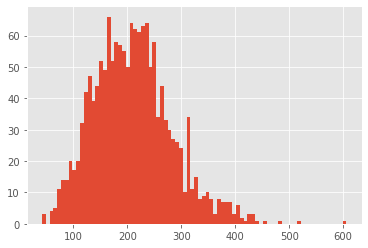

In [ ]:
%matplotlib inline
plt.hist([len(sen) for sen in sentences], bins=80)
plt.show()

In [ ]:
def decide_label(token, row_i):
  if token == 'padded':
    return label2index['irrelevant']

  biased_words = get_as_list(data.biased_words[row_i])
  outliers = get_as_list(data.outliers[row_i])
  norp = get_as_list(data.NORP[row_i])
  persons = get_as_list(data.PERSON[row_i])
  verbs = get_as_list(data.Verbs[row_i])
  adjectives = get_as_list(data.Adjectives[row_i])
  nouns = get_as_list(data.Nouns[row_i])

  if token in biased_words:
    return label2index['definitely_biased']
  elif token in outliers:
    if token in norp or token in persons or token in nouns:
      return label2index['not_biased']
    else:
      return label2index['maybe_biased']
  else:
    return label2index['irrelevant']

In [ ]:
import re
def label_token(token, row_i):
  token_clean = re.findall('[\w]+', token.lower())
  if len(token_clean) > 0:
    return decide_label(token_clean[0], row_i)
  else:
    return label2index['irrelevant']

In [ ]:
max_len = 50
X = [[w for w in tokenize_sentence(s)] for s in sentences]
new_X = []

import re
for seq in X:
  new_seq = []
  for i in range(max_len):
    try:
      new_seq.append(seq[i])
    except:
      new_seq.append("PADDED")
  new_X.append(new_seq)

In [ ]:
len(new_X)

1551

In [ ]:
def find_label(n):
  print(f'Features => {new_X[n]}')
  print(f'Label => {labels[n]}')

find_label(1)

Features => ['The', 'increasingly', 'bitter', 'dispute', 'between', 'American', 'women’s', 'national', 'soccer', 'team', 'and', 'the', 'U.S.', 'Soccer', 'Federation', 'spilled', 'onto', 'the', 'field', 'Wednesday', 'night', 'when', 'players', 'wore', 'their', 'warm-up', 'jerseys', 'inside', 'outin', 'a', 'protest', 'before', 'their', '3-1', 'victory', 'over', 'Japan.', 'PADDED', 'PADDED', 'PADDED', 'PADDED', 'PADDED', 'PADDED', 'PADDED', 'PADDED', 'PADDED', 'PADDED', 'PADDED', 'PADDED', 'PADDED']
Label => Non-biased


In [ ]:
y = labels.copy()

In [ ]:
y = [label2index[x] for x in y]

In [ ]:
f"Total training sequences => {len(new_X)} Total label sequences => {len(y)}"

'Total training sequences => 1551 Total label sequences => 1551'

For training the network we also need to change the labels y to categorial.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.1, random_state=2018)

In [ ]:
!pip install liwc

import liwc
parse, category_names = liwc.load_token_parser(
    '/content/drive/My Drive/Bias_Lexica_Kanishka_WS1920/datasets/linguistics/LIWC2015_English.dic'
    )

from collections import Counter
def get_category_counts_for_sentence(sentence):
  liwc_cat_counts = Counter(category for token in sentence for category in parse(token))
  return liwc_cat_counts

def calculate_liwc_features(token, sentence):
  liwc_sentence_counts = get_category_counts_for_sentence(sentence)
  liwc_item_counts = Counter(category for t in [token] for category in parse(t))

  #  for token
  negemo_token_count = liwc_item_counts['negemo (Negative Emotions)']
  posemo_token_count = liwc_item_counts['posemo (Positive Emotions)']
  affective_token_count = liwc_item_counts['affect (Affect)']
  drive_token_count = liwc_item_counts['drives (Drives)']
  anger_token_count = liwc_item_counts['anger (Anger)']
  risk_token_count = liwc_item_counts['risk (Risk)']

  # For sentence
  negemo_sent_count = liwc_sentence_counts['negemo (Negative Emotions)']
  posemo_sent_count = liwc_sentence_counts['posemo (Positive Emotions)']
  affective_sent_count = liwc_sentence_counts['affect (Affect)']
  drive_sent_count = liwc_sentence_counts['drives (Drives)']
  anger_sent_count = liwc_sentence_counts['anger (Anger)']
  risk_sent_count = liwc_sentence_counts['risk (Risk)']

  # calculate relative count ratios wrt the entire sentence
  if negemo_sent_count > 0:
    negemo_rel = negemo_token_count / negemo_sent_count 
  else:
    negemo_rel = 0.0

  if posemo_sent_count > 0:
    posemo_rel = posemo_token_count / posemo_sent_count 
  else:
    posemo_rel = 0.0

  if affective_sent_count > 0:
    affective_rel = affective_token_count / affective_sent_count 
  else:
    affective_rel = 0.0
  
  if drive_sent_count > 0:
    drive_rel = drive_token_count / drive_sent_count
  else:
    drive_rel = 0.0
  
  if anger_sent_count > 0:
    anger_rel = anger_token_count / anger_sent_count
  else:
    anger_rel = 0.0

  if risk_sent_count > 0:
    risk_rel = risk_token_count / risk_sent_count
  else:
    risk_rel = 0.0

  # print(f'{negemo_rel} {posemo_rel} {affective_rel} {drive_rel} {anger_rel} {risk_rel}')

  return np.array([negemo_rel, posemo_rel, affective_rel, drive_rel, anger_rel, risk_rel])

def extract_relative_liwc_features(tokens):
  li = np.zeros(shape=(50, 6))
  for i in range(50):
    li[i] = calculate_liwc_features(tokens[i], tokens)
  return li

In [ ]:
li = np.zeros(shape=(len(X_train), 50, 6))
count = 0
for sentence in X_train:
  count += 1
  print(count)
  for i in range(len(sentence)):
    li[i] = extract_relative_liwc_features(sentence)

In [ ]:
li.shape

(1395, 50, 6)

Initialize Keras + TF session

In [ ]:
batch_size = 32
import tensorflow as tf
import tensorflow_hub as hub
import keras
from keras import backend as K
sess = tf.Session()
K.set_session(sess)
import logging
tf.get_logger().setLevel(logging.ERROR)

Using TensorFlow backend.


In [ ]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [ ]:
def ELMOEmbeddingLayer(x):
  embeddings_tensor = elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]
  return embeddings_tensor

In [ ]:
from keras_contrib.layers import CRF
from keras.models import Sequential, Model
from keras.layers import GRU, Embedding, Bidirectional, LSTM, Lambda, Input, TimeDistributed, Dense, Masking, InputLayer, Reshape, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers.merge import add
from keras.layers.merge import concatenate
from keras.utils import plot_model

In [ ]:
batch_size

32

In [ ]:
n_tr_samples = 38 * batch_size
X_TR = X_train[:n_tr_samples]
X_TR_LIWC = li[:n_tr_samples]
y_TR = y_train[:n_tr_samples]

n_tes_samples = -3 * batch_size
X_VAL = X_train[n_tes_samples:]
X_VAL_LIWC = li[n_tes_samples:]
y_VAL = y_train[n_tes_samples:]

f'{len(X_TR)} {len(X_TR_LIWC)} {len(y_TR)} {len(X_VAL)} {len(X_VAL_LIWC)} {len(y_VAL)}'

'1216 1216 1216 96 96 96'

# model 1

In [ ]:
input_text = Input(shape=(np.array(X_train).shape[-1], ), dtype=tf.string)

# tokens
input_x = Input(shape=(50,), dtype=tf.string) 
x_elmo_embedding = Lambda(ELMOEmbeddingLayer, output_shape=(50, 1024))(input_x)
# m = Masking()(x_elmo_embedding)
x_conv1d = Conv1D(512, kernel_size=4, padding='same', activation='relu')(x_elmo_embedding)
pooling = MaxPooling1D()(x_conv1d)
x = Bidirectional(LSTM(units=64, return_sequences=False, recurrent_dropout=0.2, dropout=0.2))(pooling)


# LIWC embeddings
input_y = Input(shape=(50,6), dtype=tf.int32) 
y_liwc_embedding = Embedding(input_dim=50000, output_dim=8, input_length=(50, 6), trainable=True)(input_y)
reshaped_liwc_embedding = Reshape((50, 48))(y_liwc_embedding)
y_conv1d = Conv1D(32, kernel_size=4, padding='same', activation='relu')(reshaped_liwc_embedding)
y_pooling = MaxPooling1D()(y_conv1d)
y = LSTM(units=64, return_sequences=False, recurrent_dropout=0.2, dropout=0.2)(y_pooling)

concat = concatenate([x, y])

d1 = Dense(10, activation="relu")(concat)
out = Dense(1, activation="sigmoid")(d1)

model = Model([input_x, input_y], out)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 50, 6)        0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 50, 6, 8)     400000      input_25[0][0]                   
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 50, 1024)     0           input_24[0][0]                   
__________________________________________________________________________________________________
reshape_7 

In [ ]:
history = model.fit(
    [np.array(X_TR), np.array(X_TR_LIWC)], np.array(y_TR), 
    validation_data=([np.array(X_VAL), np.array(X_VAL_LIWC)], np.array(y_VAL)), 
    batch_size=batch_size, 
    epochs=10, 
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')],
    verbose=1
)

Train on 1216 samples, validate on 96 samples
Epoch 1/10
1216/1216 [==============================] - 387s 318ms/step - loss: 0.5684 - acc: 0.6801 - val_loss: 0.4360 - val_acc: 0.7500
Epoch 2/10
1216/1216 [==============================] - 378s 311ms/step - loss: 0.4390 - acc: 0.7944 - val_loss: 0.3774 - val_acc: 0.8542
Epoch 3/10
1216/1216 [==============================] - 378s 311ms/step - loss: 0.3436 - acc: 0.8594 - val_loss: 0.4043 - val_acc: 0.8125
Epoch 4/10
1216/1216 [==============================] - 379s 311ms/step - loss: 0.2487 - acc: 0.9178 - val_loss: 0.3753 - val_acc: 0.8542
Epoch 5/10
1216/1216 [==============================] - 377s 310ms/step - loss: 0.1547 - acc: 0.9515 - val_loss: 0.5895 - val_acc: 0.7812
Epoch 6/10
1216/1216 [==============================] - 378s 311ms/step - loss: 0.0783 - acc: 0.9811 - val_loss: 0.5741 - val_acc: 0.7917
Epoch 7/10
1216/1216 [==============================] - 377s 310ms/step - loss: 0.0325 - acc: 0.9910 - val_loss: 0.6480 - val_

In [ ]:
hist = pd.DataFrame(history.history)

In [ ]:
print(hist.keys())

Index(['val_loss', 'val_acc', 'loss', 'acc'], dtype='object')


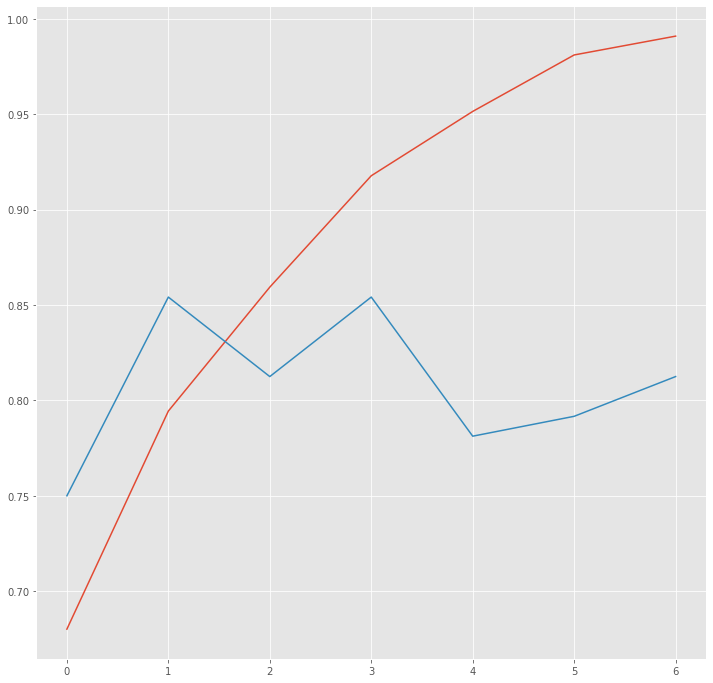

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12, 12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [ ]:
li_test = np.zeros(shape=(len(X_test), 50, 6))
count = 0
for sentence in X_test:
  count += 1
  print(count)
  for i in range(len(sentence)):
    li_test[i] = extract_relative_liwc_features(sentence)

In [ ]:
li_test.shape

(156, 50, 6)

In [ ]:
test_pred = model.predict([np.array(X_test[:128]), np.array(li_test[:128])], verbose=1)

128/128 [==============================] - 38s 297ms/step


In [ ]:
test_pred[:3]

array([[0.9951601 ],
       [0.99909973],
       [0.60607105]], dtype=float32)

In [ ]:
np.round(test_pred[:3])

array([[1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
def pred2label(pred):
    out = []
    for pred_i in pred:
      out_i = []
      for p in pred_i:
        p_i = np.round(p)
        out_i.append(idx2label[p_i])
      out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
print(pred_labels)

test_labels = [[idx2label[x]] for x in y_test[:128]]
print(test_labels[:128])

[['Biased'], ['Biased'], ['Biased'], ['Biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Non-biased'], ['Non-biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Non-biased'], ['Non-biased'], ['Non-biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Biased'], ['Biased'], ['Biased'], ['Biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Non-biased'], ['Biased'],

In [ ]:
len(test_labels)

128

In [ ]:
len(pred_labels)

128

In [ ]:
import sklearn

In [ ]:
print(sklearn.metrics.classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

      Biased       0.76      0.82      0.78        76
  Non-biased       0.70      0.62      0.65        52

    accuracy                           0.73       128
   macro avg       0.73      0.72      0.72       128
weighted avg       0.73      0.73      0.73       128



# model 2

In [ ]:
from keras.layers import Layer
class attention(Layer):
  def __init__(self,**kwargs):
    super(attention,self).__init__(**kwargs)

  def build(self,input_shape):
    self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
    # print(self.W.shape)
    self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")    
    # print(self.b.shape)    
    super(attention, self).build(input_shape)

  def call(self,x):
    et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
    at=K.softmax(et)
    at=K.expand_dims(at,axis=-1)
    output=x*at
    return K.sum(output,axis=1)

  def compute_output_shape(self,input_shape):
    return (input_shape[0],input_shape[-1])

  def get_config(self):
    return super(attention,self).get_config()

In [ ]:
input_text = Input(shape=(np.array(X_train).shape[-1], ), dtype=tf.string)

# tokens
input_x = Input(shape=(50,), dtype=tf.string) 
x_elmo_embedding = Lambda(ELMOEmbeddingLayer, output_shape=(50, 1024))(input_x)
x_conv1d = Conv1D(512, kernel_size=4, padding='same', activation='relu')(x_elmo_embedding)
pooling = MaxPooling1D()(x_conv1d)
x_attention_in = Bidirectional(LSTM(units=16, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(pooling)
x_attention_out=attention()(x_attention_in)


# LIWC embeddings
input_y = Input(shape=(50,6), dtype=tf.int32) 
y_liwc_embedding = Embedding(input_dim=50000, output_dim=8, input_length=(50, 6), trainable=True)(input_y)
reshaped_liwc_embedding = Reshape((50, 48))(y_liwc_embedding)
y_conv1d = Conv1D(32, kernel_size=4, padding='same', activation='relu')(reshaped_liwc_embedding)
y_pooling = MaxPooling1D()(y_conv1d)
y = LSTM(units=32, return_sequences=True, recurrent_dropout=0.2, dropout=0.2)(y_pooling)
y_attention_out=attention()(y)

c = concatenate([x_attention_out, y_attention_out])
print(c.shape)

# d1 = Dense(10, activation="relu")(attention_out)
out = Dense(1, activation="sigmoid")(c)

model = Model([input_x, input_y], out)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

(32, 64)


In [ ]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 50, 6)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 6, 8)     400000      input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 50, 1024)     0           input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 

In [ ]:
history = model.fit(
    [np.array(X_TR), np.array(X_TR_LIWC)], np.array(y_TR), 
    validation_data=([np.array(X_VAL), np.array(X_VAL_LIWC)], np.array(y_VAL)), 
    batch_size=batch_size, 
    epochs=10, 
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')],
    verbose=1
)

Train on 1216 samples, validate on 96 samples
Epoch 1/10
1216/1216 [==============================] - 399s 328ms/step - loss: 0.5138 - acc: 0.7352 - val_loss: 0.4204 - val_acc: 0.8125
Epoch 2/10
1216/1216 [==============================] - 393s 323ms/step - loss: 0.4198 - acc: 0.8076 - val_loss: 0.4168 - val_acc: 0.8229
Epoch 3/10
1216/1216 [==============================] - 382s 314ms/step - loss: 0.3567 - acc: 0.8429 - val_loss: 0.3847 - val_acc: 0.8438
Epoch 4/10
1216/1216 [==============================] - 385s 317ms/step - loss: 0.2897 - acc: 0.8808 - val_loss: 0.3924 - val_acc: 0.8333
Epoch 5/10
1216/1216 [==============================] - 397s 326ms/step - loss: 0.2240 - acc: 0.9219 - val_loss: 0.3938 - val_acc: 0.8333
Epoch 6/10
1216/1216 [==============================] - 404s 333ms/step - loss: 0.1425 - acc: 0.9613 - val_loss: 0.4360 - val_acc: 0.8333


In [ ]:
test_pred = model.predict([np.array(X_test[:128]), np.array(li_test[:128])], verbose=1)

128/128 [==============================] - 38s 296ms/step


In [ ]:
test_pred[:3]

array([[0.80829465],
       [0.9888502 ],
       [0.03645697]], dtype=float32)

In [ ]:
np.round(test_pred[:3])

array([[1.],
       [1.],
       [0.]], dtype=float32)

In [ ]:
def pred2label(pred):
    out = []
    for pred_i in pred:
      out_i = []
      for p in pred_i:
        p_i = np.round(p)
        out_i.append(idx2label[p_i])
      out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
print(pred_labels)

test_labels = [[idx2label[x]] for x in y_test[:128]]
print(test_labels[:128])

[['Biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Non-biased'], ['Non-biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Non-biased'], ['Non-biased'], ['Biased'], ['Non-biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Non-biased'], ['Non-biased'], ['Non-biased'], ['Non-biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Biased'], ['Biased'], ['Biased'], ['Biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Biased'], ['B

In [ ]:
len(test_labels)

128

In [ ]:
len(pred_labels)

128

In [ ]:
import sklearn

In [ ]:
print(sklearn.metrics.classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

      Biased       0.78      0.79      0.78        76
  Non-biased       0.69      0.67      0.68        52

    accuracy                           0.74       128
   macro avg       0.73      0.73      0.73       128
weighted avg       0.74      0.74      0.74       128



# model 3

In [ ]:
from keras.layers import Layer
class attention(Layer):
  def __init__(self,**kwargs):
    super(attention,self).__init__(**kwargs)

  def build(self,input_shape):
    self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
    # print(self.W.shape)
    self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")    
    # print(self.b.shape)    
    super(attention, self).build(input_shape)

  def call(self,x):
    et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
    at=K.softmax(et)
    at=K.expand_dims(at,axis=-1)
    output=x*at
    return K.sum(output,axis=1)

  def compute_output_shape(self,input_shape):
    return (input_shape[0],input_shape[-1])

  def get_config(self):
    return super(attention,self).get_config()

In [ ]:
input_text = Input(shape=(np.array(X_train).shape[-1], ), dtype=tf.string)

# tokens
input_x = Input(shape=(50,), dtype=tf.string) 
x_elmo_embedding = Lambda(ELMOEmbeddingLayer, output_shape=(50, 1024))(input_x)
x_attention_in = Bidirectional(LSTM(units=16, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(x_elmo_embedding)
x_attention_out=attention()(x_attention_in)


# LIWC embeddings
input_y = Input(shape=(50,6), dtype=tf.int32) 
y_liwc_embedding = Embedding(input_dim=50000, output_dim=8, input_length=(50, 6), trainable=True)(input_y)
reshaped_liwc_embedding = Reshape((50, 48))(y_liwc_embedding)
y = Bidirectional(LSTM(units=16, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(reshaped_liwc_embedding)
y_attention_out=attention()(y)

c = concatenate([x_attention_out, y_attention_out])
d = Dense(64, activation="relu")(c)
out = Dense(1, activation="sigmoid")(d)

model = Model([input_x, input_y], out)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 50, 6)        0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 50, 6, 8)     400000      input_18[0][0]                   
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 50, 1024)     0           input_17[0][0]                   
__________________________________________________________________________________________________
reshape_6 

In [ ]:
history = model.fit(
    [np.array(X_TR), np.array(X_TR_LIWC)], np.array(y_TR), 
    validation_data=([np.array(X_VAL), np.array(X_VAL_LIWC)], np.array(y_VAL)), 
    batch_size=batch_size, 
    epochs=10, 
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')],
    verbose=1
)

Train on 1216 samples, validate on 96 samples
Epoch 1/10
1216/1216 [==============================] - 276s 227ms/step - loss: 0.5814 - acc: 0.6974 - val_loss: 0.4606 - val_acc: 0.8021
Epoch 2/10
1216/1216 [==============================] - 270s 222ms/step - loss: 0.4626 - acc: 0.7780 - val_loss: 0.4105 - val_acc: 0.8229
Epoch 3/10
1216/1216 [==============================] - 270s 222ms/step - loss: 0.3953 - acc: 0.8051 - val_loss: 0.3906 - val_acc: 0.8333
Epoch 4/10
1216/1216 [==============================] - 268s 220ms/step - loss: 0.3510 - acc: 0.8495 - val_loss: 0.4125 - val_acc: 0.8021
Epoch 5/10
1216/1216 [==============================] - 270s 222ms/step - loss: 0.2939 - acc: 0.8783 - val_loss: 0.3991 - val_acc: 0.8333
Epoch 6/10
1216/1216 [==============================] - 270s 222ms/step - loss: 0.2370 - acc: 0.9079 - val_loss: 0.4279 - val_acc: 0.8021


In [ ]:
li_test = np.zeros(shape=(len(X_test), 50, 6))
count = 0
for sentence in X_test:
  count += 1
  print(count)
  for i in range(len(sentence)):
    li_test[i] = extract_relative_liwc_features(sentence)

In [ ]:
li_test.shape

(156, 50, 6)

In [ ]:
test_pred = model.predict([np.array(X_test[:128]), np.array(li_test[:128])], verbose=1)

128/128 [==============================] - 27s 213ms/step


In [ ]:
test_pred[:3]

array([[0.7251195 ],
       [0.9967854 ],
       [0.07888815]], dtype=float32)

In [ ]:
np.round(test_pred[:3])

array([[1.],
       [1.],
       [0.]], dtype=float32)

In [ ]:
def pred2label(pred):
    out = []
    for pred_i in pred:
      out_i = []
      for p in pred_i:
        p_i = np.round(p)
        out_i.append(idx2label[p_i])
      out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
print(pred_labels)

test_labels = [[idx2label[x]] for x in y_test[:128]]
print(test_labels[:128])

[['Biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Non-biased'], ['Non-biased'], ['Non-biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Non-biased'], ['Non-biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Biased'], ['Biased'], ['Biased'], ['Biased'], ['Biased'], ['Biased'], ['Biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Non-biased'], ['Biased'], ['Biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Non-biased'], ['Biased'], ['Biased'],

In [ ]:
len(test_labels)

128

In [ ]:
len(pred_labels)

128

In [ ]:
import sklearn

In [ ]:
print(sklearn.metrics.classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

      Biased       0.78      0.79      0.78        76
  Non-biased       0.69      0.67      0.68        52

    accuracy                           0.74       128
   macro avg       0.73      0.73      0.73       128
weighted avg       0.74      0.74      0.74       128

